# Prototype 6: Using CoastSat to download ROIs
- Author: Sharon Fitzpatrick
- Date: 1/18/2022

## Description
This prototype showcases an interactive map where users can click on various ROIs to download their data with CoastSat.

## The Workflow
1. The user draws a bounding box
2. The user runs the code to clip the coastline geojson to the bounding box
3. The user runs the code to add the coastline within the bounding box to the map. (The coastline will be in yellow)
4. The user runs the code to to generate polygons along the portion of the coastline vector within the bounding box
5. The user runs the code to plot the polygons and associated markers to the map.
6. The user selects at least one ROI for download with CoastSat by clicking on any ROI on the map
7. The user runs the code to download the geojson for the ROIs they selected
8. The user runs the code to download all the data using CoastSat for the ROIs they selected.

# Get the Bounding Box Geojson
## Directions
1. Use the square drawing button to draw a bounding box somewhere along the coast

## !! Warning !!
- If the bounding box drawn is too small or too large you will need to re-run the code to generate the map again.

In [1]:
from ipywidgets import Layout
map_settings={
"center_point":( 36.100206171202295, -75.71024865851251),
"zoom":13,
 "draw_control":False,
 "measure_control":False, 
 "fullscreen_control":False, 
 "attribution_control":True,
 "Layout":Layout(width='100%', height='100px')
}

In [2]:
from ipyleaflet import DrawControl, Map, GeoJSON, Polygon
import leafmap
from shapely.geometry import shape, LineString, Point
from area import area
import geopandas as gpd
import json
import os
from shapely.ops import unary_union
import numpy as np
from geojson import Point, Feature, FeatureCollection, dump


# Empty list to hold all the polygons drawn by the user
shapes_list=[]

# Disable polyline, circle, and rectangle 
m = leafmap.Map(draw_control=map_settings["draw_control"],
                measure_control=map_settings["measure_control"],
                fullscreen_control=map_settings["fullscreen_control"],
                attribution_control=map_settings["attribution_control"],
                center=map_settings["center_point"],
                zoom=map_settings["zoom"],
                layout=map_settings["Layout"])

draw_control = DrawControl()

draw_control.polyline = {}
draw_control.circlemarker = {}
# Custom styles for polygons and rectangles
draw_control.polygon = {
    "shapeOptions": {
        "fillColor": "green",
        "color": "green",
        "fillOpacity": 0.2,
        "Opacity": 0.2
    },
    "drawError": {
        "color": "#dd253b",
        "message": "Ops!"
    },
    "allowIntersection": False,
    "transform":True
}

draw_control = DrawControl()
draw_control.rectangle = {
    "shapeOptions": {
        "fillColor": "green",
        "color": "green",
        "fillOpacity": 0.1,
        "Opacity": 0.1
    },
    "drawError": {
        "color": "#dd253b",
        "message": "Ops!"
    },
    "allowIntersection": False,
    "transform":True
}

# Each time a polygon is drawn it is appended to the shapeslist which is used to create the bounding box
def handle_draw(target, action, geo_json):
    if draw_control.last_action == 'created'and draw_control.last_draw['geometry']['type']=='Polygon' :
        shapes_list.append( draw_control.last_draw['geometry'])
    if draw_control.last_action == 'deleted':
        label1.value=str(f"{draw_control.last_draw['geometry']['type']}  {draw_control.last_action}")
        shapes_list.pop()

draw_control.on_draw(handle_draw)
m.add_control(draw_control)

m


Map(center=[36.100206171202295, -75.71024865851251], controls=(ZoomControl(options=['position', 'zoom_in_text'…

### Select the name of the file that will hold the geojson for all the ROIs generated

In [3]:
filename = "roi.geojson"

# Check the size of the Bounding Box 
1. Obtain the area of the bounding box using **calculate_area_bbox**
3. Check if its a valid size suing **check_bbox_size**

### Custom Exceptions for Invalid BBox size
1. BboxTooLargeError
2. BboxTooSmallError

In [4]:
class BboxTooLargeError(Exception):
    """BboxTooLargeError: raised when bounding box is larger than MAX_BBOX_SIZE
    Args:
        Exception: Inherits from the base exception class
    """
    def __init__(self, msg="The bounding box was too large."):
        self.msg=msg
        super().__init__(self.msg)
    def __str__(self):
        return (f"{self.msg}")
    
class BboxTooSmallError(Exception):
    """BboxTooLargeError: raised when bounding box is smaller than MIN_BBOX_SIZE
    Args:
        Exception: Inherits from the base exception class
    """
    def __init__(self, msg="The bounding box was too small."):
        self.msg=msg
        super().__init__(self.msg)
    def __str__(self):
        return (f"{self.msg}")

In [5]:
def calculate_area_bbox(bbox):
    bbox_area=round(area(bbox),2)
    print(f"Area: {bbox_area} meters squared")
    return bbox_area

## Function erase_bbox
- Clears any data associated with invalid bbox
- NOTE: If the bbox size is invalid re-run the code to re-create the map


In [6]:
def erase_bbox(draw_control : 'ipyleaflet.leaflet.DrawControl',shapeslist:list)-> list:
    """Erases bounding box from map and deletes the contents of the shapeslist"""
    draw_control.clear()
    shapeslist=[]
    return shapeslist

## Check if the bounding box size is allowed

In [8]:
def check_bbox_size(bbox_area:float,shapes_list:list):
    """"Raises an exception and clears the map if the size of the bounding box is too large or small."""
    # CONSTANT SIZE VARIABLES
    # UNITS = Sq. Meters
    MAX_BBOX_SIZE=1000000000
    MIN_BBOX_SIZE=300
    # Check if the size is greater than MAX_BBOX_SIZE
    if bbox_area > MAX_BBOX_SIZE:
        shapes_list=erase_bbox(draw_control,shapes_list)
        raise BboxTooLargeError
    # Check if size smaller than MIN_BBOX_SIZE
    elif bbox_area < MIN_BBOX_SIZE:
        shapes_list=erase_bbox(draw_control,shapes_list)
        raise BboxTooSmallError

In [9]:
if not shapes_list == []:
    last_index=len(shapes_list)-1
#     The last index in the shapes_list was the last shape drawn
    bbox_area=calculate_area_bbox(shapes_list[last_index])
    check_bbox_size(bbox_area,shapes_list)
else:
     print("ERROR.\nYou must draw a bounding box somewhere on the coast first.")

Area: 24088522.35 meters squared


# Clip the Bounding Box and Vector
---
1. Convert the bounding box to a geopandas geodataframe using **create_geodataframe_from_bbox**
2. Print the bounds of the geodataframe

In [10]:
def create_geodataframe_from_bbox(shapes_list:list)->"geopandas.geodataframe.GeoDataFrame":
    if not shapes_list == []:
        geom = [shape(i) for i in shapes_list]
        geojson_bbox=gpd.GeoDataFrame({'geometry':geom})
        geojson_bbox.crs='EPSG:4326'
        geojson_bbox.plot()
        return geojson_bbox
    else:
        print("ERROR.\nYou must draw a bounding box somewhere on the coast first.")
        return None

Geojson bounds
        minx       miny       maxx       maxy
0 -75.772945  36.091104 -75.704786  36.126405



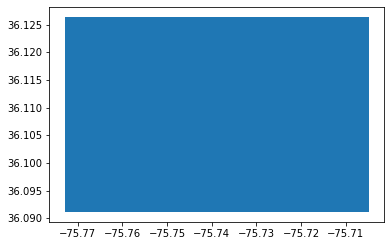

In [11]:
geojson_bbox=create_geodataframe_from_bbox(shapes_list)
if (geojson_bbox is not None):
    print(f"Geojson bounds\n{geojson_bbox.bounds}\n")
else:
    print("ERROR.\nYou must draw a bounding box somewhere on the coast first.")

### Download the Shorline Vector
- https://geodata.lib.berkeley.edu/catalog/stanford-xv279yj9196

In [12]:
def get_shoreline_vector(filename:str)->"geopandas.geodataframe.GeoDataFrame":
    if os.path.exists(filename):
         with open(filename, 'r') as f:
            coastline_vector=gpd.read_file(f)
    else:
        print('File does not exist. Please download the coastline_vector necessary here: https://geodata.lib.berkeley.edu/catalog/stanford-xv279yj9196 ')
        raise FileNotFoundError
    return coastline_vector      

In [13]:
coastline_vector=get_shoreline_vector("stanford-xv279yj9196.geojson")
coastline_vector

,id,f_code,acc,exs,soc,geometry
0,xv279yj9196.1,BA010,1,44,USA,"MULTILINESTRING ((-96.93882 28.02606, -96.9354..."
1,xv279yj9196.2,BA010,1,44,USA,"MULTILINESTRING ((-96.91022 28.06370, -96.9123..."
2,xv279yj9196.3,BA010,1,44,USA,"MULTILINESTRING ((-96.89713 28.06679, -96.8990..."
3,xv279yj9196.4,BA010,1,44,USA,"MULTILINESTRING ((-96.88841 28.07634, -96.8849..."
4,xv279yj9196.5,BA010,1,44,USA,"MULTILINESTRING ((-96.91283 28.12183, -96.9144..."
...,...,...,...,...,...,...
3094,xv279yj9196.3095,BA010,1,44,USA,"MULTILINESTRING ((-160.08739 22.02016, -160.08..."
3095,xv279yj9196.3096,BA010,1,44,USA,"MULTILINESTRING ((-159.39618 22.22735, -159.39..."
3096,xv279yj9196.3097,BA010,1,44,USA,"MULTILINESTRING ((-130.01769 55.91194, -130.02..."
3097,xv279yj9196.3098,BA010,1,44,USA,"MULTILINESTRING ((-160.87141 56.00000, -160.86..."


### Clip the shorline vector to the bounding box

In [14]:
def clip_coastline_to_bbox(coastline_vector, geojson_bbox)->"geopandas.geodataframe.GeoDataFrame":
    #clip coastal polyline
    roi_coast=gpd.clip(coastline_vector, geojson_bbox)
    roi_coast=roi_coast.to_crs('EPSG:4326')
    return roi_coast

In [15]:
roi_coast=clip_coastline_to_bbox(coastline_vector, geojson_bbox)
roi_coast

,id,f_code,acc,exs,soc,geometry
1889,xv279yj9196.1875,BA010,1,44,USA,"MULTILINESTRING ((-75.72433 36.12640, -75.7236..."


## Display the Shoreline Vector

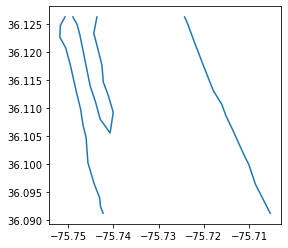

In [16]:
if not roi_coast.empty:
    roi_coast.plot()
else:
    print("ERROR.\nThe bounding box provided did not intersect with the coastline vector provided.")

### Add the coastline vector within the bounding box to the map

In [17]:
vector_within_bounding_box_json=roi_coast.to_json()
# to_json generates a string that is json format
res = json.loads(vector_within_bounding_box_json)
geo_json_vector = GeoJSON(
    data=res,
    style={
        'color':'yellow','fill_color':'yellow' ,'opacity': 1, 'dashArray': '5', 'fillOpacity': 0.5, 'weight': 4
    },
    hover_style={
        'color': 'white', 'dashArray': '4', 'fillOpacity': 0.7
    },
)
m.add_layer(geo_json_vector)
m

Map(bottom=411668.0, center=[36.10917188776314, -75.62068420217034], controls=(ZoomControl(options=['position'…

# Generate Polygons along the selected portion of the coastline vector
---

### Convert the clipped portion of the coastline into geojson

In [18]:
# vector_within_bounding_box_geojson
vector_within_bounding_box_geojson = json.loads(vector_within_bounding_box_json)

In [19]:
print(f"There are {len(vector_within_bounding_box_geojson['features'])} feature(s) in the bounding box")

There are 1 feature(s) in the bounding box


# Convert the geometry of coastline within the bounding box to a list of linestrings
For each of the linestrings and the linestrings within the multilinestring coastline that make up the coastline vector add them to the list of linestrings. These linestrings will have pointers interpolated along them later

In [20]:
def create_linestring_list(vector_within_bounding_box_geojson:dict)->list:
    """
    Create a list of linestrings from the multilinestrings and linestrings that compose the vector

    Arguments:
    -----------
    vector_within_bounding_box_geojson: dict
        geojson vector 
    Returns:
    -----------
    lines_list: list
        list of multiple shapely.geometry.linestring.LineString that represent each segment of the vector
    """
    lines_list=[]
    length_vector_bbox_features=len(vector_within_bounding_box_geojson['features'])
    length_vector_bbox_features

    if(length_vector_bbox_features != 1):
        for i in range(0,length_vector_bbox_features):
            if  vector_within_bounding_box_geojson['features'][i]['geometry']['type'] == 'MultiLineString':
                for y in range(len(vector_within_bounding_box_geojson['features'][i]['geometry']['coordinates'])):
                    line=LineString(vector_within_bounding_box_geojson['features'][i]['geometry']['coordinates'][y])
                    lines_list.append(line)
            elif  vector_within_bounding_box_geojson['features'][i]['geometry']['type'] == 'LineString':
                line=LineString(vector_within_bounding_box_geojson['features'][i]['geometry']['coordinates'])
                lines_list.append(line)
    else:
        for i in range(0,len(vector_within_bounding_box_geojson['features'])):
            if  vector_within_bounding_box_geojson['features'][0]['geometry']['type'] == 'MultiLineString':
                for y in range(len(vector_within_bounding_box_geojson['features'][0]['geometry']['coordinates'])):
                    line=LineString(vector_within_bounding_box_geojson['features'][0]['geometry']['coordinates'][y])
                    lines_list.append(line)
            elif  vector_within_bounding_box_geojson['features'][i]['geometry']['type'] == 'LineString':
                line=LineString(vector_within_bounding_box_geojson['features'][i]['geometry']['coordinates'])
                lines_list.append(line)
    return lines_list

In [21]:
lines_list=create_linestring_list(vector_within_bounding_box_geojson)

In [22]:
print(f"The number of linestring(s) in lines_list: {len(lines_list)}")

The number of linestring(s) in lines_list: 3


## Interpolate Equal Distances Between Each Point on the Vector
For each LineString that makes up the coastline :
1. Calculate the distance between each point so that they are equally spaced
2. Create a tuple of each of the equally spaced distance points
3. Check if the linestring is closed and if it is then choose the 1st coordinate as the boundary
4. Interpolate the linestring for each of the distances points calculated earlier
5. Add the new multipoint generated by the interpolation to multipoint_list

In [23]:
def interpolate_points(lines_list:list,num_pts=10)->list:
    """
    Create a list of multipoints for the interpolated points along each line in the lines_list

    Arguments:
    -----------
    lines_list: list
        list of multiple shapely.geometry.linestring.LineString that represent each segment of the vector
    
    num_pts: int
        integer value representing the number of interpolated points created per LineString
        
    Returns:
    -----------
    multipoint_list: list
    A list of multiple shapely.geometry.multipoint.MultiPoint 
    """
    # multipoint_list holds the multipoint for each feature of the coastline within the bbox
    multipoint_list=[]

    for i in range(len(lines_list)):
        line=lines_list[i]
        distance_delta=line.length/num_pts
        distances = np.arange(0, line.length, distance_delta)
        if lines_list[i].is_closed:
            #Its a closed shape so its boundary points are NULL
            boundary=Point(lines_list[i].coords[0])
        else: 
            boundary=lines_list[i].boundary.geoms[0]
        points = [lines_list[i].interpolate(distance) for distance in distances] + [boundary]
        multipoint = unary_union(points) 
        multipoint
        multipoint_list.append(multipoint)
    return multipoint_list

In [24]:
multipoint_list=interpolate_points(lines_list)

## Convert the multipoint from the interpolation to a tuple
- ipyleaflet requires that the points be a tuple to be plotted onto the map

In [25]:
def convert_multipoints_to_tuples(multipoint_list:list)-> list:
    """
    Create a list of tuples for the points in multipoint_list

    Arguments:
    -----------
    multipoint_list: list
        A list of multiple shapely.geometry.multipoint.MultiPoint
    Returns:
    -----------
    points_list_collection: list
        A list of tuples each tuple represents a single point
    """
    points_list_collection=[]
    for multipoint in  multipoint_list:
        # First get each point from the multipoint object
        points_array=[point for point in multipoint.geoms]
        # Create an empty array to hold all the points as tuples
        points_list=[]
        # For each point swap lat and lng because ipyleaflet swaps them
        for point in points_array:
            point_tuple=(point.coords[0][1],point.coords[0][0])
            points_list.append(point_tuple)

        points_list_collection.append(points_list)
    return points_list_collection

In [26]:
points_list_collection=convert_multipoints_to_tuples(multipoint_list)

## Function to Convert ipyleaflet Polygon Points to GeoJson
1. Ipyleaflet draws its shapes in lat,lng format and it must be converted to lng, lat for geojson.
2. In order to correctly draw a rectangle in geojson the order of the points matters as well.

In [27]:
def convert_to_geojson(upper_right_y : float, upper_right_x: float,upper_left_y: float, upper_left_x: float,lower_left_y: float,  lower_left_x: float,lower_right_y: float,lower_right_x: float) -> dict:
    """Convert the 4 corners of the rectangle into geojson  """
    geojson_feature={}
    geojson_feature["type"]="Feature"
    geojson_feature["properties"]={}
    geojson_feature["geometry"]={}
    
    geojson_polygon={}
    geojson_polygon["type"]="Polygon"
    geojson_polygon["coordinates"]=[]
#     The coordinates(which are 1,2 arrays) are nested within a parent array
    nested_array=[]
    nested_array.append([upper_right_x, upper_right_y])
    nested_array.append([upper_left_x, upper_left_y])
    nested_array.append([lower_left_x, lower_left_y])
    nested_array.append([lower_right_x, lower_right_y])
    #GeoJson rectangles have the first point repeated again as the last point
    nested_array.append([upper_right_x, upper_right_y])

    geojson_polygon["coordinates"].append(nested_array)
    
    geojson_feature["geometry"]=geojson_polygon
    return geojson_feature

## Function to Write Polygons in GeoJson to a .geojson file
1. Pass the filename and the geojson from ***convert_to_geojson()***

In [28]:
def write_to_geojson_file(filename : str,geojson_polygons : dict):
    """Make a filename.geojson file from dictionary geojson_polygons  """
    features = []
    count=0
    for geoObj in geojson_polygons["features"]:
        features.append(Feature(properties={"id":count },geometry=geoObj["geometry"]))
        count=count+1

    feature_collection = FeatureCollection(features)

    with open(f'{filename}', 'w') as f:
        dump(feature_collection, f)

## Create a Rectangle For Each Interpolated Point on the Vector
1. Create a list to hold all the polygons to be added on to the map
2. Convert each of the rectangles to geojson for further analysis later using ***convert_to_geojson()***

In [29]:
def create_reactangles(points_list_collection: list)-> dict:
    """
    Create the geojson rectangles for each point in the points_list_collection

    Arguments:
    -----------
    points_list_collection: list
        list of tuples containing all the interpolated points along the given vector

    Returns:
    -----------
    geojson_polygons: dict
       geojson dictionary contains all the rectangles generated
    """
    size=0.002                                         
    geojson_polygons={"type": "FeatureCollection","features":[]}

    # Create a rectangle at each point on the line
    # Swap the x and y for each point because ipyleaflet swaps them for draw methods
    for points_list in points_list_collection:
        for point in points_list:
            upper_right_x=point[0]-(size/2)
            upper_right_y=point[1]-(size/2)
            upper_left_x=point[0]+(size/2)
            upper_left_y=point[1]-(size/2)
            lower_left_x=point[0]+(size/2)
            lower_left_y=point[1]+(size/2)
            lower_right_x=point[0]-(size/2)
            lower_right_y=point[1]+(size/2)
            #Convert each set of points to geojson (DONT swap x and y this time)
            geojson_polygon=convert_to_geojson(upper_right_x, upper_right_y,upper_left_x, upper_left_y,lower_left_x,lower_left_y,lower_right_x,lower_right_y)
            geojson_polygons["features"].append(geojson_polygon)
    return geojson_polygons

### Create the ROIs along the coastline and write their data to roi.geojson

In [30]:
geojson_polygons=create_reactangles(points_list_collection)

In [31]:
write_to_geojson_file(filename,geojson_polygons)

## Check if all the ROIs overlap with their neighbors

In [32]:
def check_shapes_overlap(filename):
    geo_series=gpd.GeoSeries.from_file(filename)
    shapes_overlap=True
    last_index=geo_series.index[-1]
    for index in geo_series.index:
        geo_series_next=geo_series[index]
        for inner_index in geo_series.index:
            if inner_index==last_index and not geo_series_next.overlaps(geo_series[inner_index]) :
                shapes_overlap=False
            if geo_series_next.overlaps(geo_series[inner_index]) and index != inner_index:
                break
    return shapes_overlap

In [33]:
num_pts=20
too_many_ROI=False
all_shapes_overlap=False
# Convert to while loop when test is done
while all_shapes_overlap==False and too_many_ROI==False:
    multipoint_list=interpolate_points(lines_list,num_pts)
    points_list_collection=convert_multipoints_to_tuples(multipoint_list)
    geojson_polygons=create_reactangles(points_list_collection)
    write_to_geojson_file(filename,geojson_polygons)
    all_shapes_overlap=check_shapes_overlap(filename)
    if not all_shapes_overlap:
        if num_pts == 100:
            too_many_ROI=True
        elif num_pts > 100:
            num_pts=100
        else:
            num_pts=num_pts*2
    print(f"num_pts increased to: {num_pts}")
    

num_pts increased to: 40
num_pts increased to: 40


# Add the Features to the Map
---
### Markers
    1. Each marker has the lat and lng on hover and on click as a popup
### ROI
    1. Each rectangle can be click on to select it for download with data
    2. Click the rectangle again to unselect it

In [34]:
import copy
from ipyleaflet import LayerGroup
from ipyleaflet import Map, Marker, MarkerCluster
from ipywidgets import HTML
import geojson

# @TODO    Add Try Except later
# Raise excecption for invalid file type
# Raise exception for invalid file format
    # geojson layer with hover handler
with open(filename) as f:
    data = geojson.load(f)

#     Add style to each feature in the geojson
for feature in data["features"]:
    feature["properties"]["style"] = {
        "color": "grey",
        "weight": 1,
         "fillColor": "grey",
        "fillOpacity": 0.2,
     }

selected_set = set()
selected_layer = None


def convert_selected_set_to_geojson(selected_set):
#     Create a geojson feature collection with no features
    geojson = {"type": "FeatureCollection", "features": []}
# Iterate through all the features in the geojson data and check if its name is in the selected_set
# if its name is then add it as a geojson feature
    geojson["features"] = [
        feature
        for feature in data["features"]
        if feature["properties"]["id"] in selected_set
    ]
 #     change the style for the selected features
    for feature in data["features"]:
        feature["properties"]["style"] = {
            "color": "blue",
            "weight": 2,
             "fillColor": "grey",
             "fillOpacity": 0.2,
          }
    return geojson

# If  properties is none is means there is no name and thus nothing to add
# Modify this for my version
# This function allows for the feature to be removed from the selected portion if it is clicked again after being selected
def selected_onclick_handler(event=None, id=None, properties=None, **args):
    global selected_layer
    if properties is None:
        return
    cid = properties["id"]
    selected_set.remove(cid)
#     If the selected_layer is included then remove it
    if selected_layer is not None:
         m.remove_layer(selected_layer)
    selected_layer = GeoJSON(
        data=convert_selected_set_to_geojson(selected_set),
        name="Selected ROIs",
        hover_style={"fillColor": "blue"},
    )
    selected_layer.on_click(selected_onclick_handler)
    m.add_layer(selected_layer)

    # selected_onclick_handler mirrors this function
def geojson_onclick_handler(event=None, id=None, properties=None, **args):
    print("Click Registered")
    global selected_layer
#     Custom properties associated with geojson
    if properties is None:
           return
    cid = properties["id"]
#     Add the property to the selected_set (unordered, no duplicates, no index)
    selected_set.add(cid)
#     Remove the previously selected layer from map layer
    if selected_layer is not None:
        m.remove_layer(selected_layer)
# Create a new layer from the selected geojson on the map 
# call convert_selected_set_to_geojson() to style the selected geojson
    selected_layer = GeoJSON(
        data=convert_selected_set_to_geojson(selected_set),
        name="Selected ROIs",
        hover_style={"fillColor": "blue"},
    )
# Add a on_click handler to the selected_layer
    selected_layer.on_click(selected_onclick_handler)
# Add the selected layer to the map
    m.add_layer(selected_layer)


geojson_layer = GeoJSON(
    data=data, name="ROIs", hover_style={"fillColor": "red"}
    )
geojson_layer.on_click(geojson_onclick_handler)
m.add_layer(geojson_layer)
m


Map(bottom=411668.0, center=[36.10917188776314, -75.62068420217034], controls=(ZoomControl(options=['position'…

## Add the Marker cluser to the map

In [35]:
from ipyleaflet import LayerGroup
from ipyleaflet import Map, Marker, MarkerCluster
from ipywidgets import HTML

markers = ()
for points_list in points_list_collection:
    for point in points_list:
        marker = Marker(location=point,draggable=False,title=f"Location:({point[1]},{point[0]})")
        message = HTML(value=f"Location:({point[1]},{point[0]})")
        marker.popup = message
        markers=markers + (marker,)

m.add_layer(MarkerCluster(name = "CoastSat Shoreline Data",markers = markers,))

m


Map(bottom=411668.0, center=[36.10917188776314, -75.62068420217034], controls=(ZoomControl(options=['position'…

# Add the Selected ROIs a Dictionary 
---
1. Print the ID's of the selected ROIs
2. Add the selected ROIs to the dictionary, selected_ROI
3. Optionally, print the selected_ROI
4. Download the geojson file of the selected_ROI

In [36]:
print(selected_set)

set()


In [ ]:
# Create a dictionary for the selected ROIs and add the user's selected ROIs to it
selected_ROI={}
selected_ROI["features"] = [
        feature
        for feature in data["features"]
        if feature["properties"]["id"] in selected_set
    ]

In [ ]:
# Optional Code: Prints the geosjon info of the selected_roi
# for ROI in selected_ROI["features"]:
#     print(ROI)

### Download the Selected ROI(s) to a geojson file

In [ ]:
selected_roi_file="selected_roi.geojson"
write_to_geojson_file(selected_roi_file,selected_ROI)

## Download the bounding box's data from CoastSat
---
1. Preview the data available with CoastSat's check_images_available()
2. Download the data availble CoastSat's retrieve_images()
3. View the metadata downloaded with CoastSat's get_metadata()

In [ ]:
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
from datetime import datetime
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects
# NOTE: modify the "import gda"l in SDS_download to "from osgeo import gdal" to reslove the module not found error

### For each item in selected_ROI
1. Create a coastSatBBOX
2. Set Coast's polygon equal to the coastSatBBOX
3. Set all the necessary CoastSat parameters
4. Check images available for download

In [ ]:
def check_images_available_selected_ROI(selected_ROI:dict)->list:
    list_of_inputs=[]
    if selected_ROI["features"] != []:
        for ROI in selected_ROI["features"]:
            coastSatBBOX=ROI["geometry"]["coordinates"]
            polygon=coastSatBBOX
            # it's recommended to convert the polygon to the smallest rectangle (sides parallel to coordinate axes)       
            polygon = SDS_tools.smallest_rectangle(polygon)
            # date range
            dates = ['2018-12-01', '2019-01-01']
            # satellite missions
            sat_list = ['S2','L7','L8']
            # name of the site
            sitename = 'NARRA'
            # directory where the data will be stored
            filepath = os.path.join(os.getcwd(), 'data')
            # put all the inputs into a dictionnary
            inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'sitename': sitename, 'filepath':filepath}
            # before downloading the images, check how many images are available for your inputs
            SDS_download.check_images_available(inputs)
            list_of_inputs.append(inputs)
    return list_of_inputs

In [ ]:
list_of_inputs=check_images_available_selected_ROI(selected_ROI)
list_of_inputs
if list_of_inputs == []:
    print("Error: No ROIs were selected. Please click a valid ROI on the map")

### Download the Images with CoastSat's retrieve_images()

In [ ]:
for inputs in list_of_inputs:
  # inputs['include_T2'] = True
    metadata = SDS_download.retrieve_images(inputs)  

## Print the Metadata Downloaded

In [ ]:
for inputs in list_of_inputs:
    metadata = SDS_download.get_metadata(inputs) 
    print(metadata)